<a href="https://colab.research.google.com/github/KyleRoss-rice/SignIconicityPredictor/blob/main/tools/Dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [195]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

## Fetch original ASL-LEX 2.0 dataset from our server


In [196]:
!wget notcol.net/research/mlproject/ASL-LEX2_Oct21_2020.csv
!rm ASL-LEX2_Oct21_2020.csv.* #cleanup any extra copies


--2020-10-24 22:50:09--  http://notcol.net/research/mlproject/ASL-LEX2_Oct21_2020.csv
Resolving notcol.net (notcol.net)... 192.99.169.208
Connecting to notcol.net (notcol.net)|192.99.169.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3480805 (3.3M) [text/csv]
Saving to: ‘ASL-LEX2_Oct21_2020.csv.1’

ASL-LEX2_Oct21_2020 100%[===================>]   3.32M  8.91MB/s    in 0.4s    

2020-10-24 22:50:09 (8.91 MB/s) - ‘ASL-LEX2_Oct21_2020.csv.1’ saved [3480805/3480805]



## Create pandas object from the source dataset

In [209]:
source_data = pd.read_csv('ASL-LEX2_Oct21_2020.csv')
working_data = source_data.copy()

## Convert classes to integers

#### Selected Fingers


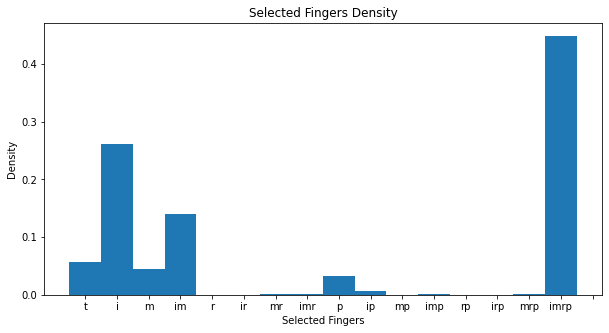

In [217]:
selected_fingers = source_data['Selected Fingers']

fingers = ['t', 'i', 'm', 'im', 'r', 'ir', 'mr', 'imr', 'p', 'ip', 'mp', 'imp', 'rp', 'irp', 'mrp', 'imrp'] 
labels = np.arange(0, 17)
mapping = dict(zip(fingers, labels))
new_values = [mapping[i] for i in selected_fingers]

working_data['Selected Fingers'] = new_values

plt.figure(figsize=(10,5))
plt.title('Selected Fingers Density')
plt.xticks(labels, fingers)
plt.xlabel('Selected Fingers')
plt.ylabel('Density')
plt.hist(new_values, bins=labels - 0.5, density=True); 

## Feature selection

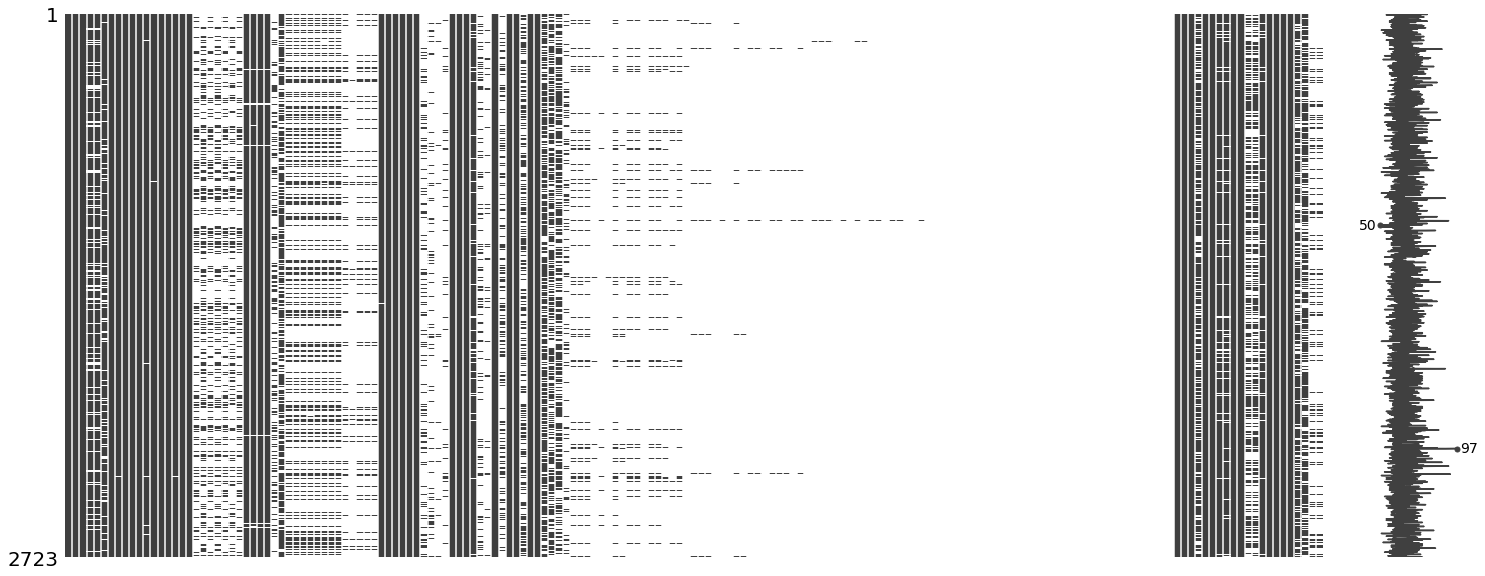

In [199]:
msno.matrix(source_data);

In [200]:
n_rows = len(source_data)
n_columns = len(source_data.columns)

#### Remove handpicked features (columns) that are unrelated to psycholinguistic properties

In [201]:
features_to_trim = ['Batch', 'List', 'Item', 'Sign Onset (ms)', 'Sign Offset (ms)', 
                    'Duration (ms)', 'Video Length (ms)', 'In CDI', 'English Word Frequency',
                    'Frequency SD', 'Frequency N', 'Frequency Z', 
                    'Frequency SD (Nonnative)', 'Frequency N (Nonnative)', 'Frequency Z (Nonnative)',
                    'Frequency Sd (Native)', 'Frequency N (Native)', 'Frequency Z (Native)',
                    'Non-Signer Iconicity SD', 'Non-Signer Iconicity Z', 'Non-Signer Iconicity N']

working_data.drop(features_to_trim, 1, inplace=True)
n_trimmed = len(features_to_trim)

print(f'Original dataset contains {n_columns} columns')
n_columns -= n_trimmed
print(f'{n_trimmed} columns were trimmed. {n_columns} columns remain')

Original dataset contains 177 columns
21 columns were trimmed. 156 columns remain


#### Keep features (columns) and points (rows) that are at least 80% non-NA


In [202]:
working_data = working_data.dropna(1, thresh=n_rows * .8)

n_trimmed = n_columns - len(working_data.columns)
n_columns -= n_trimmed
print(f'{n_trimmed} columns were trimmed. {n_columns} columns remain')

126 columns were trimmed. 30 columns remain


In [203]:
working_data = working_data.dropna(0, thresh=n_columns * .8)

n_trimmed = n_rows - len(working_data)
print(f'{n_trimmed} rows were trimmed. {n_rows - n_trimmed} rows remain')


0 rows were trimmed. 2723 rows remain


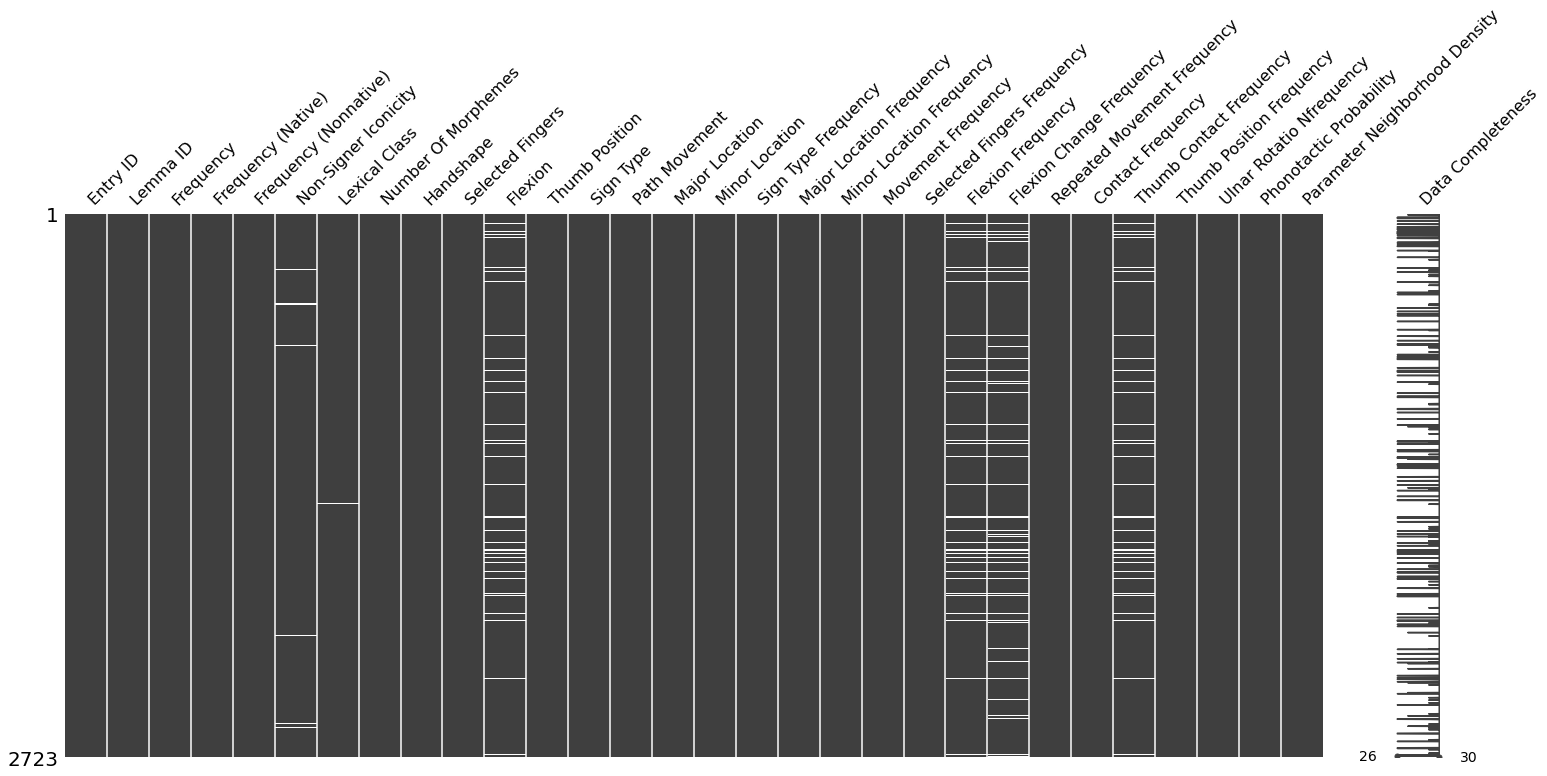

In [204]:
msno.matrix(working_data, labels=True);

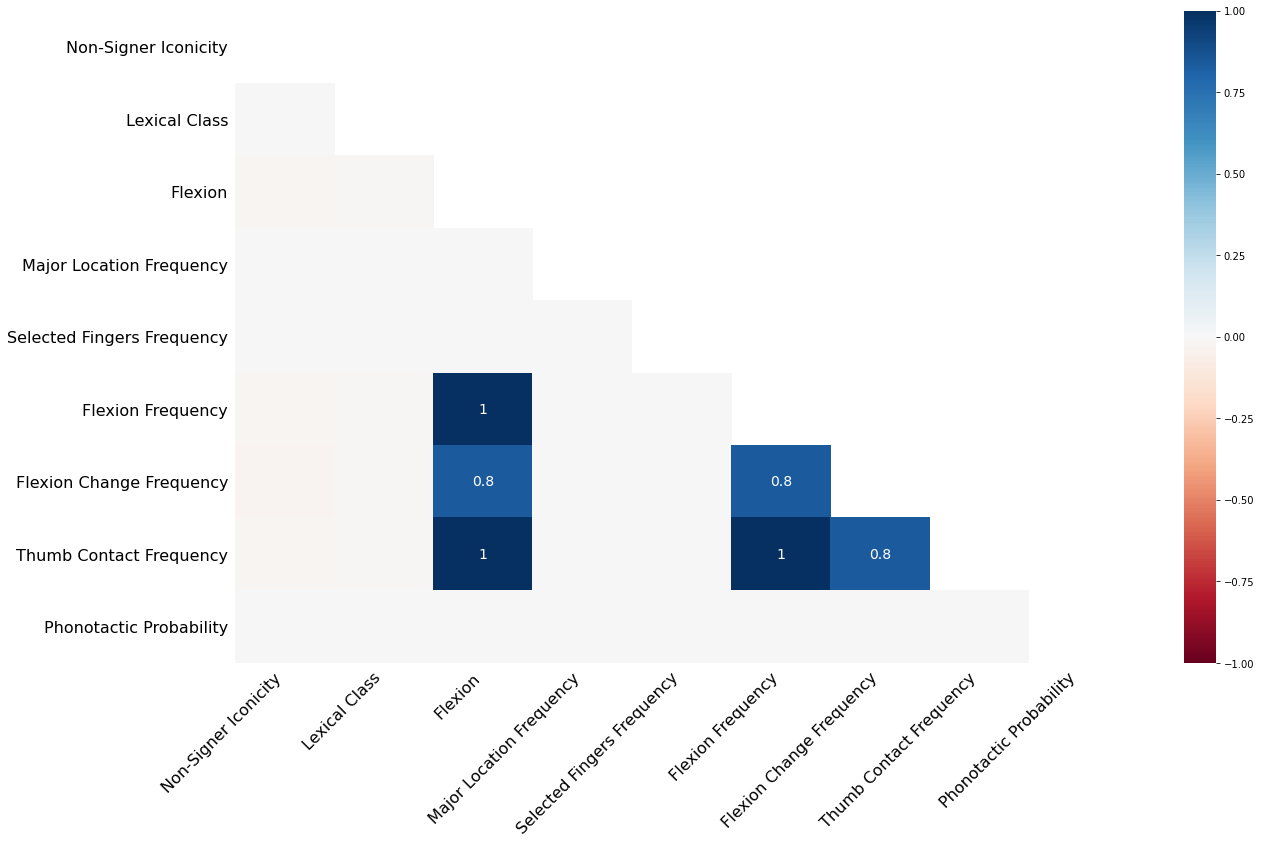

In [205]:
msno.heatmap(working_data);

#### Drop all entries containing a NA → No imputing


228 rows were dropped


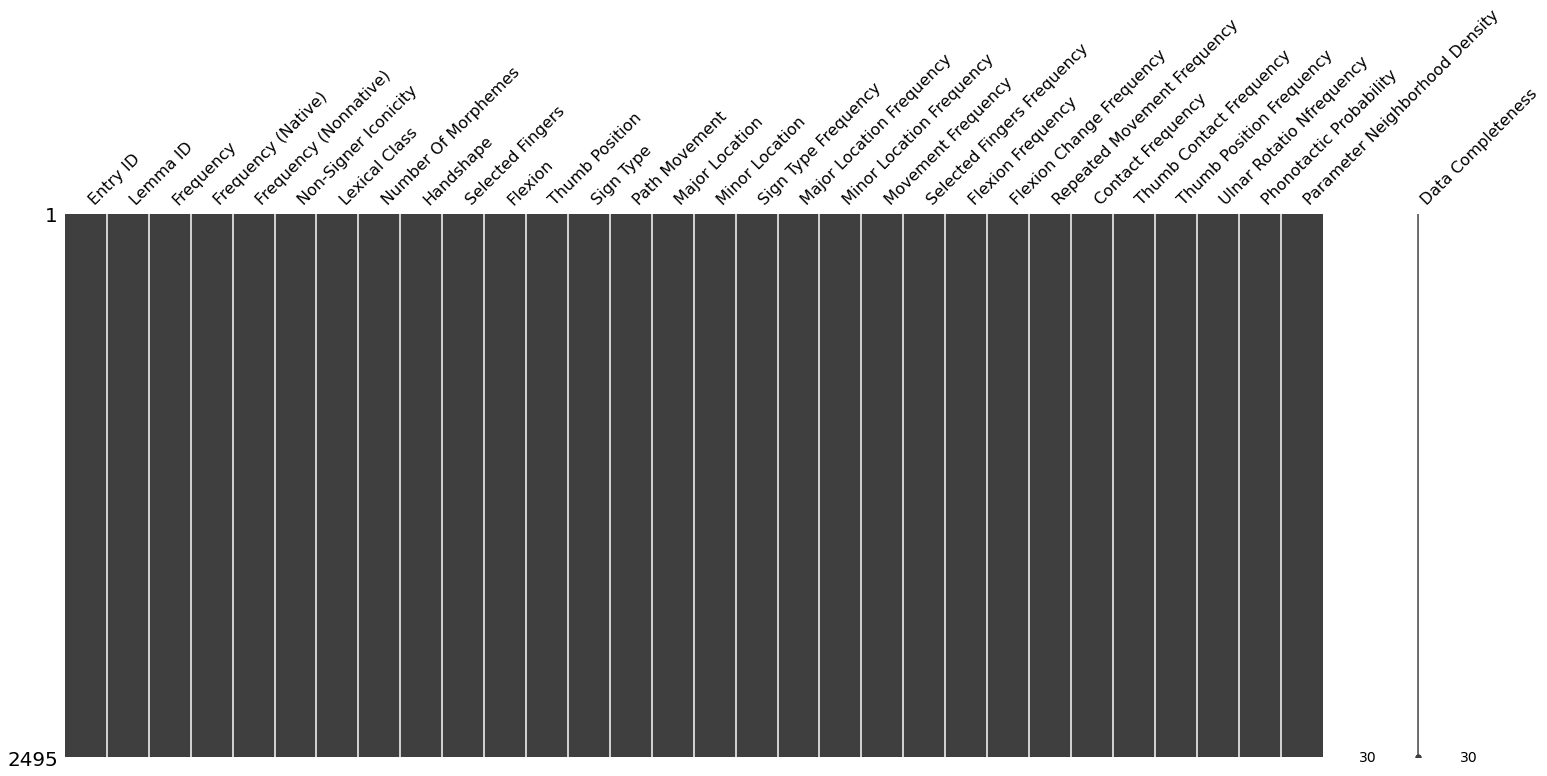

In [206]:
working_data.dropna(0, inplace=True)
print(f'{n_rows - len(working_data)} rows were dropped')
msno.matrix(working_data, labels=True);

## Dimensionality reduction


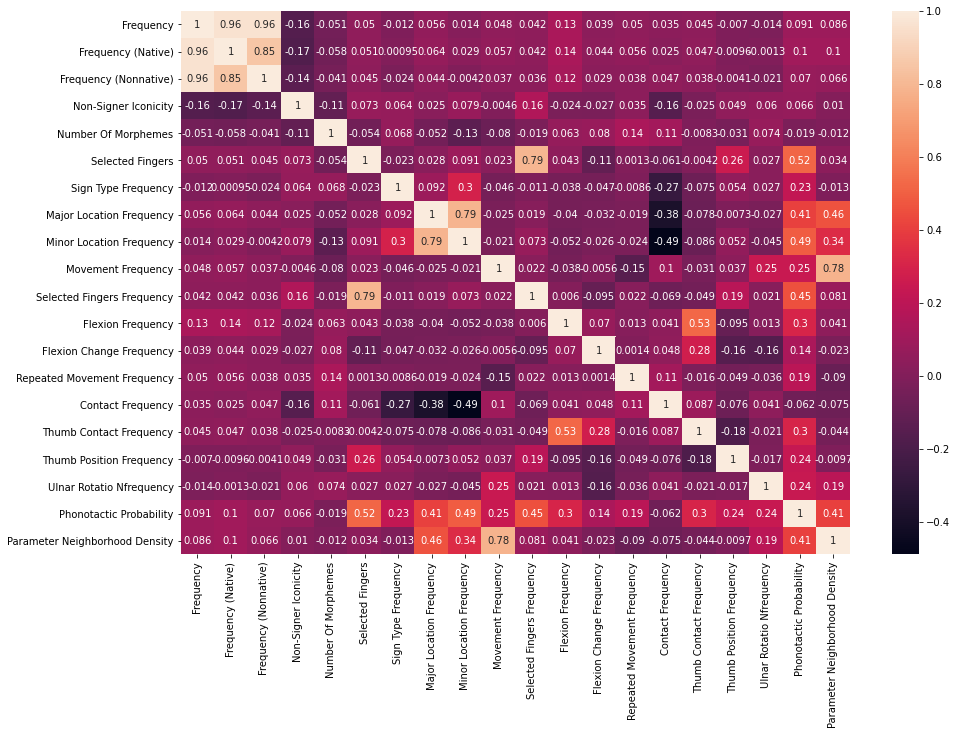

In [207]:
plt.figure(figsize=(15,10))
sns.heatmap(working_data.corr(), annot=True);